In [ ]:
#@title Download Packages
import os
import sys
import matplotlib.pyplot as plt
clipstyler_dir = os.path.join("/content", "clipstyler")

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/paper11667/CLIPstyler/ $clipstyler_dir
sys.path.append(clipstyler_dir)

from PIL import Image
import numpy as np
import sys
import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models

import StyleNet
import utils
import clip
import torch.nn.functional as F
from template import imagenet_templates

from PIL import Image
import PIL
from torchvision import utils as vutils
import argparse
from torchvision.transforms.functional import adjust_contrast

In [ ]:
#@title Functions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG = models.vgg19(pretrained=True).features
VGG.to(device)

for parameter in VGG.parameters():
    parameter.requires_grad_(False)

def img_denormalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = image*std +mean
    return image

def img_normalize(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def clip_normalize(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device)
    std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image


def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]

    loss_var_l2 = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)

    return loss_var_l2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default ups

After 0 criterions:
Total loss:  10435.7236328125
Content loss:  5.608800888061523
patch loss:  1.013671875
dir loss:  0.94775390625
TV loss:  0.40305042266845703


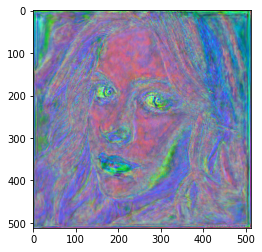

After 50 criterions:
Total loss:  8492.6953125
Content loss:  2.7080819606781006
patch loss:  0.86328125
dir loss:  0.63671875
TV loss:  0.23227347433567047


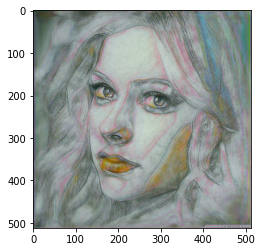

After 100 criterions:
Total loss:  7954.27197265625
Content loss:  2.243360996246338
patch loss:  0.81884765625
dir loss:  0.4990234375
TV loss:  0.26782751083374023


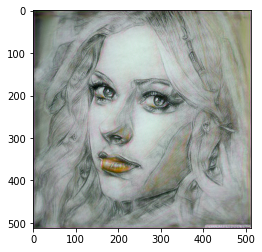

After 150 criterions:
Total loss:  7681.71240234375
Content loss:  1.9020050764083862
patch loss:  0.80126953125
dir loss:  0.3681640625
TV loss:  0.28649359941482544


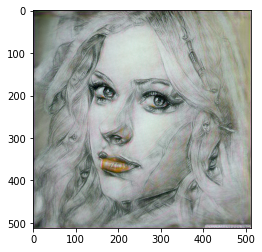

After 200 criterions:
Total loss:  7507.287109375
Content loss:  1.7982428073883057
patch loss:  0.78662109375
dir loss:  0.314453125
TV loss:  0.3009638786315918


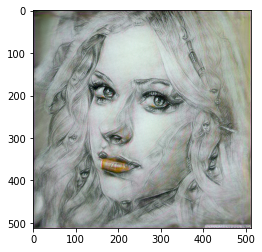

In [ ]:
from IPython.display import display
from argparse import Namespace

source = "a Photo"

text = "Sketch with black pencil" #@param {"type": "string"}
crop_size = 128 #@param {"type": "integer"}
image_dir = "/content/clipstyler/test_set/face.jpg" #@param {type: "string"}


training_iterations = 100 #@param {type: "integer"}


training_args = {
    "lambda_tv": 2e-3,
    "lambda_patch": 9000,
    "lambda_dir": 500,
    "lambda_c": 150,
    "crop_size": 128,
    "num_crops":64,
    "img_height":512,
    "img_width":512,
    "max_step":training_iterations,
    "lr":5e-4,
    "thresh":0.7,
    "content_path":image_dir,
    "text":text
}

args = Namespace(**training_args)

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

content_path = args.content_path
content_image = utils.load_image2(content_path, img_height=args.img_height,img_width =args.img_width)

content_image = content_image.to(device)

content_features = utils.get_features(img_normalize(content_image), VGG)

target = content_image.clone().requires_grad_(True).to(device)

style_net = StyleNet.UNet()
style_net.to(device)

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = args.lambda_c

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
steps = args.max_step

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

output_image = content_image

m_cont = torch.mean(content_image,dim=(2,3),keepdim=False).squeeze(0)
m_cont = [m_cont[0].item(),m_cont[1].item(),m_cont[2].item()]

cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
    transforms.Resize(224)
])

clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

prompt = args.text

source = "a Photo"

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features = text_features.mean(axis=0, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach()
    text_source = text_source.mean(axis=0, keepdim=True)
    text_source /= text_source.norm(dim=-1, keepdim=True)
    source_features = clip_model.encode_image(clip_normalize(content_image,device))
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))


num_crops = args.num_crops
for epoch in range(0, steps+1):

    scheduler.step()
    target = style_net(content_image,use_sigmoid=True).to(device)
    target.requires_grad_(True)

    target_features = utils.get_features(img_normalize(target), VGG)

    content_loss = 0

    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)

    loss_patch=0
    img_proc =[]
    for n in range(num_crops):
        target_crop = cropper(target)
        target_crop = augment(target_crop)
        img_proc.append(target_crop)

    img_proc = torch.cat(img_proc,dim=0)
    img_aug = img_proc

    image_features = clip_model.encode_image(clip_normalize(img_aug,device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))

    img_direction = (image_features-source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)

    text_direction = (text_features-text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1- torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] =0
    loss_patch+=loss_temp.mean()

    glob_features = clip_model.encode_image(clip_normalize(target,device))
    glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))

    glob_direction = (glob_features-source_features)
    glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)

    loss_glob = (1- torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()

    reg_tv = args.lambda_tv*get_image_prior_losses(target)

    total_loss = args.lambda_patch*loss_patch + content_weight * content_loss+ reg_tv+ args.lambda_dir*loss_glob
    total_loss_epoch.append(total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print("After %d iters:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('patch loss: ', loss_patch.item())
        print('dir loss: ', loss_glob.item())
        print('TV loss: ', reg_tv.item())

    if epoch %20 ==0:

        output_image = target.clone()
        output_image = torch.clamp(output_image,0,1)
        output_image = adjust_contrast(output_image,1.5)
        plt.imshow(utils.im_convert2(output_image))
        plt.show()


